# Xgboost Model for kaggle competition

## 1. Data Preparation

### 1.1 load the data and see the basic information

In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='tab10')
%matplotlib inline

# View train dataset and test dataset.
# Note: actually, I crawled Hong Kong's 2017-2018 holiday data and added a column named holiday to the original train.csv and test.csv
train=pd.read_csv('train.csv',index_col='id')
print(train.info())
print(train.describe())

test=pd.read_csv('test.csv',index_col='id')
print(test.info())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     14006 non-null  object 
 1   speed    14006 non-null  float64
 2   holiday  14006 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 437.7+ KB
None
              speed       holiday
count  14006.000000  14006.000000
mean      32.779118      0.053763
std       13.573813      0.225557
min        2.573417      0.000000
25%       19.301089      0.000000
50%       36.580595      0.000000
75%       45.877665      0.000000
max       53.161286      1.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     3504 non-null   object
 1   holiday  3504 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 82.1+ KB
None
           holida

### 1.2 View the distribution of speeds

[Text(0.5, 1.0, 'boxplot of speed')]

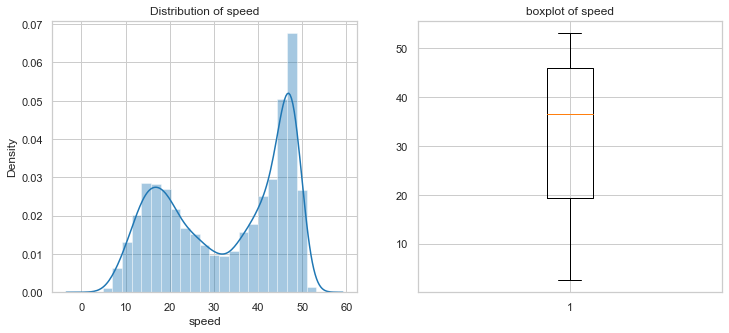

In [2]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.set_size_inches(12,5)

sns.distplot(train['speed'],ax=ax1)
ax2.boxplot(train['speed'])
ax1.set(xlabel='speed',title='Distribution of speed')
ax2.set(title='boxplot of speed')

### 1.3 tranform the timestamp form

In [3]:
all_data=pd.concat([train,test],ignore_index=True)
all_data.rename(columns={'date': 'datetime'},inplace=True)

tmp=pd.to_datetime(all_data.datetime,format='%d/%m/%Y %H:%M')
all_data['date']=tmp.dt.date
all_data['hour']=tmp.dt.hour
all_data['year']=tmp.dt.year
all_data['month']=tmp.dt.month
all_data['weekday']=tmp.dt.weekday+1
all_data['workingday'] = (tmp.dt.weekday<6).astype(int)

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17510 entries, 0 to 17509
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17510 non-null  object 
 1   speed       14006 non-null  float64
 2   holiday     17510 non-null  int64  
 3   date        17510 non-null  object 
 4   hour        17510 non-null  int64  
 5   year        17510 non-null  int64  
 6   month       17510 non-null  int64  
 7   weekday     17510 non-null  int64  
 8   workingday  17510 non-null  int32  
dtypes: float64(1), int32(1), int64(5), object(2)
memory usage: 1.1+ MB


In [5]:
train=all_data[all_data.speed.isnull()==False]

## 2. Feature Engineering

### 2.1 The effect of hour on speed (take average for the same hour)

Text(0.5, 1.0, 'The average speed per hour')

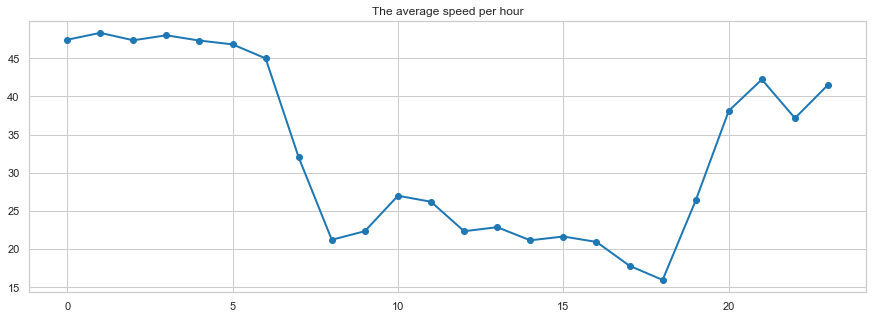

In [6]:
hour_df = train.groupby(['hour'], as_index=False).agg({'speed':'mean'})
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(hour_df['hour'] , hour_df['speed'],marker='o',linewidth=2)
ax.set_title('The average speed per hour')

### 2.2 The effect of weekday on speed (take average for the same hour)

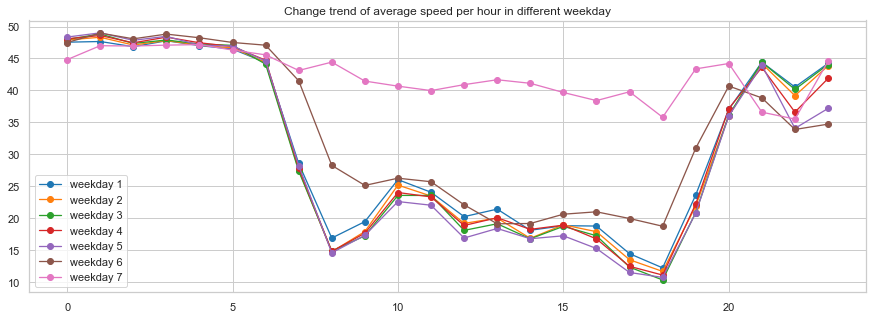

In [7]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

for i in range(1,8):
    saterday_df=train[train['weekday']==i]
    saterday_df = saterday_df.groupby(['hour'], as_index=False).agg({'speed':'mean'})
    ax.plot(saterday_df['hour'] , saterday_df['speed'] ,marker='o', linewidth=1.3 , label='weekday '+str(i))
    
ax.set_title('Change trend of average speed per hour in different weekday')
ax.legend()

# modes of Monday to Saturday are close, and mode of Sunday is different

### 2.3 The effect of holiday on speed (take average for the same hour)

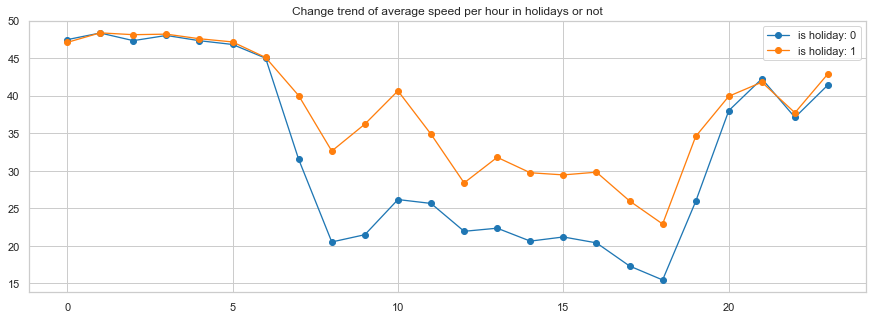

In [8]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

for i in range(0,2):
    saterday_df=train[train['holiday']==i]
    saterday_df = saterday_df.groupby(['hour'], as_index=False).agg({'speed':'mean'})
    ax.plot(saterday_df['hour'] , saterday_df['speed'] ,marker='o', linewidth=1.3 , label='is holiday: '+str(i))
    
ax.set_title('Change trend of average speed per hour in holidays or not')
ax.legend()

### 2.4 The effect of date, month, weekday and year on speed

   year      speed
0  2017  32.619414
1  2018  32.983865


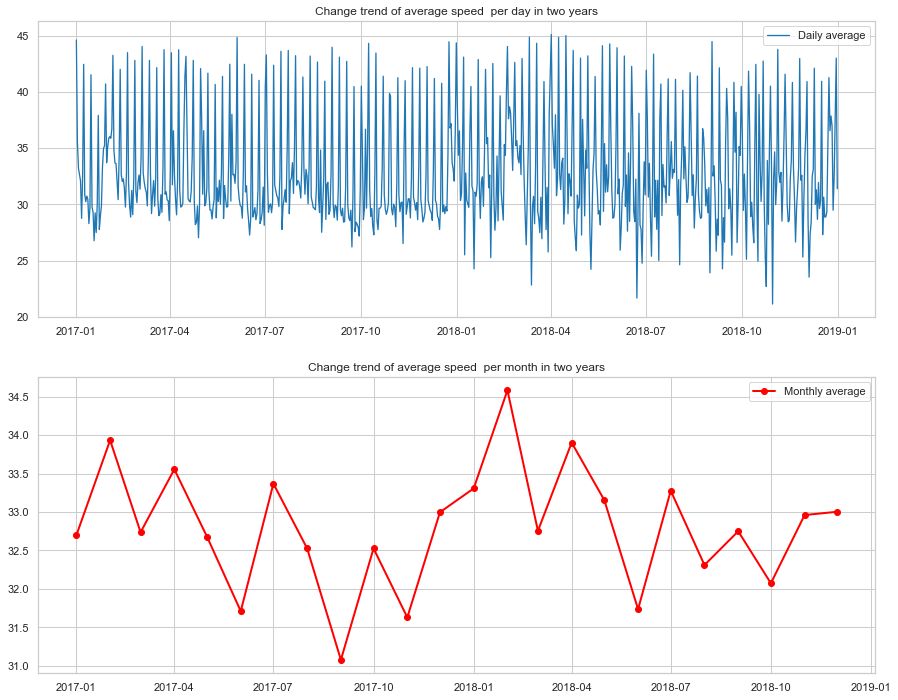

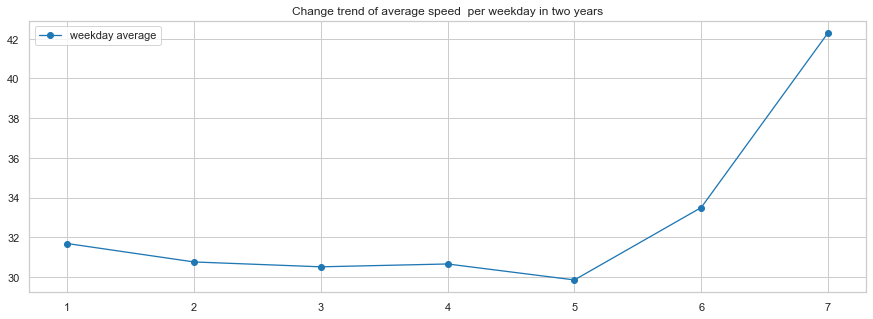

In [9]:
count_df = train.groupby(['date','weekday'], as_index=False).agg({'year':'mean',
                                                                      'month':'mean',
                                                                      'speed':'mean'})
count_df['date']=pd.to_datetime(count_df['date'])

count_month = count_df.groupby(['year','month'], as_index=False).agg({'weekday':'min',
                                                                      'speed':'mean'})
    
count_month.rename(columns={'weekday':'day'},inplace=True)
count_month['date']=pd.to_datetime(count_month[['year','month','day']])

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Use a line chart to show the trend of speed over time
ax1.plot(count_df['date'] , count_df['speed'] , linewidth=1.3 , label='Daily average')
ax1.set_title('Change trend of average speed  per day in two years')
ax1.legend()

ax2.plot(count_month['date'] , count_month['speed'] , color='r',marker='o', linewidth=2 , label='Monthly average')
ax2.set_title('Change trend of average speed  per month in two years')
ax2.legend()

count_weekday= train.groupby(['weekday'], as_index=False).agg({'speed':'mean'})
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(count_weekday['weekday'] , count_weekday['speed'] ,marker='o', linewidth=1.3 , label='weekday average')
ax.set_title('Change trend of average speed  per weekday in two years')
ax.legend()

count_year = count_month.groupby(['year'], as_index=False).agg({'speed':'mean'})
print(count_year)

### 2.5 Feature Selection

In [10]:
all_data.columns

Index(['datetime', 'speed', 'holiday', 'date', 'hour', 'year', 'month',
       'weekday', 'workingday'],
      dtype='object')

In [11]:
# According to the previous observations, 
# I decide to use the five items as the feature values: hour, month, weekday, workingday, and holiday

# convert month and weekday to one-hot
dummies_month = pd.get_dummies(all_data['month'], prefix= 'month')
dummies_weekday=pd.get_dummies(all_data['weekday'],prefix='weekday')

all_data=pd.concat([all_data,dummies_month,dummies_weekday],axis=1)

# Separate training set and test set
train = all_data[pd.notnull(all_data['speed'])]
test= all_data[~pd.notnull(all_data['speed'])]
yLabels=train['speed']

In [12]:
train.columns

Index(['datetime', 'speed', 'holiday', 'date', 'hour', 'year', 'month',
       'weekday', 'workingday', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'],
      dtype='object')

In [13]:
# Discard unnecessary columns
dropFeatures = ['datetime' ,'speed', 'date','month','weekday',]

train = train.drop(dropFeatures , axis=1)
test = test.drop(dropFeatures , axis=1)

In [14]:
train.columns

Index(['holiday', 'hour', 'year', 'workingday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'],
      dtype='object')

## 3. Model Training

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [27]:
if __name__ == '__main__':

#         cv_params = {'n_estimators': [100, 200, 300, 400, 500]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#                        'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'n_estimators': [80,85,90,95,100,105,110]}
#         ther_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#                        'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'max_depth': [3, 4, 5, 6, 7, 8], 'min_child_weight': [9, 10, 11, 12, 13, 14, 15, 16]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'gamma': [0, 0.01, 0.05, 0.15, 0.1]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 13, 'seed': 0,
#                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 13, 'seed': 0,
#                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.15, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 13, 'seed': 0,
#                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.15, 'reg_alpha': 0, 'reg_lambda': 1}

#         cv_params = {'reg_alpha': [0, 0.2, 0.3, 0.5, 1, 1.5], 'reg_lambda': [1, 1.5, 2]}
#         other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 13, 'seed': 0,
#                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.15, 'reg_alpha': 0, 'reg_lambda': 1}

        cv_params = {'learning_rate': [0.01,0.05,0.1,0.15,0.5]}
        other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 13, 'seed': 0,
                         'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.15, 'reg_alpha': 0.2, 'reg_lambda': 1.5}

        model = xgb.XGBRegressor(**other_params)
        optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
        optimized_GBM.fit(train, yLabels)
        evalute_result = optimized_GBM.cv_results_
        print('Results of each iteration: {0}'.format(evalute_result))
        print('The best value of the parameter: {0}'.format(optimized_GBM.best_params_))
        print('Best model score: {:.6f}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished


Results of each iteration: {'mean_fit_time': array([1.17301927, 1.215767  , 1.27162747, 1.24562082, 1.12612109]), 'std_fit_time': array([0.04401245, 0.06103947, 0.06460481, 0.0381259 , 0.17006806]), 'mean_score_time': array([0.01137195, 0.01496263, 0.01646581, 0.01497936, 0.01248822]), 'std_score_time': array([0.0004868 , 0.00063062, 0.00166409, 0.00121317, 0.0018218 ]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1, 0.15, 0.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.1}, {'learning_rate': 0.15}, {'learning_rate': 0.5}], 'split0_test_score': array([-242.41073772,  -14.99636869,  -14.77604981,  -15.34848569,
        -17.72674641]), 'split1_test_score': array([-229.2611159 ,  -14.38277012,  -13.70822085,  -14.12251296,
        -15.40615625]), 'split2_test_score': array([-215.19091463,  -14.43852941,  -13.67108283,  -14.06967607,
   

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

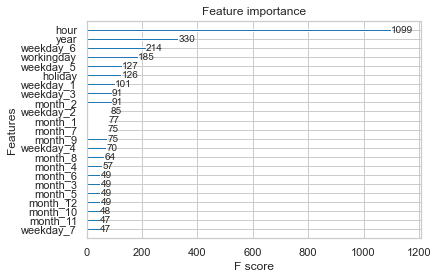

In [29]:
# plot the importance of each feature

model = xgb.XGBRegressor(**other_params)
model.fit(train, yLabels)
from xgboost import plot_importance
plot_importance(model)

## 4. Prediction in test dataset and save the result

In [30]:
all_data.head()

,datetime,speed,holiday,date,hour,year,month,weekday,workingday,month_1,...,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1/1/2017 0:00,43.002930,1,2017-01-01,0,2017,1,7,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1/1/2017 1:00,46.118696,1,2017-01-01,1,2017,1,7,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1/1/2017 2:00,44.294158,1,2017-01-01,2,2017,1,7,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1/1/2017 3:00,41.067468,1,2017-01-01,3,2017,1,7,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1/1/2017 4:00,46.448653,1,2017-01-01,4,2017,1,7,0,1,...,0,0,0,0,0,0,0,0,0,1


In [41]:
predsTest= pd.DataFrame(model.predict(test))
outcome=pd.concat([all_data[~pd.notnull(all_data['speed'])][['datetime']].reset_index(),predsTest],axis=1)
outcome.drop(columns=['index'],inplace=True)
outcome.datetime = outcome.index
outcome.columns=['id','speed']
outcome.to_csv('speed_prediction.csv',index=False)

In [42]:
outcome

,id,speed
0,0,48.094910
1,1,47.477901
2,2,36.377068
3,3,28.718721
4,4,38.697842
...,...,...
3499,3499,13.123688
3500,3500,23.553566
3501,3501,44.739613
3502,3502,37.892803
